In [34]:
# Imports and Initial Setup
import os, copy, torch, itertools
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import numpy as np
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Name to use for saving the model
model_path = 'BERT Sentiment Model'

# Dataset (CSV) Column Names
sentence_column_name = "Sentences"
sentiment_column_name = "Final_Sent"
dataset_split_folder_name = "Annotated Dataset Split"

# To Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [35]:
# Data Splitting
def split_data():
    # Create output directory if it doesn't exist
    os.makedirs(dataset_split_folder_name, exist_ok=True)
    
    # Define file paths
    train_path = os.path.join(dataset_split_folder_name, 'train.csv')
    val_path = os.path.join(dataset_split_folder_name, 'validation.csv')
    test_path = os.path.join(dataset_split_folder_name, 'test.csv')
    
    # Check if split files already exist
    if all(os.path.exists(f) for f in [train_path, val_path, test_path]):
        train = pd.read_csv(train_path)
        val = pd.read_csv(val_path)
        test = pd.read_csv(test_path)
        
        return train, val, test
    else:
        # Load the dataset
        df = pd.read_csv('annotated_dataset.csv')
        
        # Split data into 80% training+validation and 20% test
        remaining, test = train_test_split(df, test_size=0.2, random_state=42)
        # Split the remaining 80% into 70% training and 10% validation (0.125 of 80% = 10% overall)
        train, val = train_test_split(remaining, test_size=0.125, random_state=42)
        
        # Save splits
        train.to_csv(train_path, index=False)
        val.to_csv(val_path, index=False)
        test.to_csv(test_path, index=False)
    
        return train, val, test

train, val, test = split_data()

train, val, test

(                                              Sentences  \
 0     Nate Silver's Bolton has Kamala Harris leading...   
 1     This razor-thin margin demonstrates that Penns...   
 2                               Trump leads by just 1%.   
 3     How critical is winning the state of Michigan ...   
 4     Am I saying Trump's going to win it by 21 poin...   
 ...                                                 ...   
 4016       Kamala Harris, I believe, fits all of those.   
 4017  This idea that she's going to magically do bet...   
 4018  It holds 15 electoral votes and it is very muc...   
 4019  Harris holds narrow leads in four critical bat...   
 4020  And so, I refuse a meeting with Donald Trump o...   
 
      Presidential_Candidate         State  Vote_1  Vote_2  Final_Sent  
 0             Kamala Harris      Michigan       1       0           1  
 1              Donald Trump  Pennsylvania       1       1           1  
 2              Donald Trump      Michigan       1       0 

In [36]:
# Set up the model and compute class weights
def compute_class_weights(labels):
    """
    Calculate weights for each class to handle imbalanced data
    For example, if we have 100 positive but only 10 negative samples,
    negative samples will get higher weight to balance their importance
    """
    # Shift labels for model [-1, 0, 1] to [0, 1, 2]
    mapped_labels = labels + 1
    # Count how many samples we have of each class
    class_counts = np.bincount(mapped_labels)
    # Give higher weights to classes with fewer samples
    weights = 1. / class_counts
    # Normalize weights to sum to number of classes
    weights = weights * len(class_counts) / weights.sum()
    return torch.FloatTensor(weights)

# Calculate weights for each class from training data
class_weights = compute_class_weights(train[sentiment_column_name].values)
class_weights = class_weights.to(device)  # Move weights to GPU if available

class_weights

tensor([0.9941, 1.1636, 0.8422])

In [37]:
# Base BERT model to use
model_name = 'bert-base-uncased'

# Create a custom BERT model that can handle weighted loss
class BertWithWeightedLoss(BertForSequenceClassification):
    """
    Custom BERT model that applies different weights to each class
    This helps handle imbalanced datasets better
    """
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights # Store class weights for loss calculation
    
    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get model outputs without computing loss
        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None # Set to None to prevent automatic loss calculation
        )
        
        # Calculate weighted loss if labels are provided (training phase)
        if labels is not None:
            # Create loss function with class weights
            loss_fct = CrossEntropyLoss(weight=self.class_weights)
            # Calculate loss using model predictions and true labels
            loss = loss_fct(
                outputs.logits.view(-1, self.num_labels),  # Reshape predictions
                labels.view(-1)                            # Reshape labels
            )
            outputs.loss = loss  # Add loss to outputs
        
        return outputs

# Initialize the tokenizer that will convert text to numbers
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [38]:
# Data Preparation Functions
def create_data_loader(data, tokenizer, batch_size):
    """
    Convert text data into a format BERT can understand and create batches
    
    Args:
        data: DataFrame containing text and labels
        tokenizer: BERT tokenizer to convert text to numbers
        batch_size: How many samples to process at once
    
    Returns:
        DataLoader that yields batches of processed data
    """
    # Convert text to BERT input format with progress bar
    encodings = tokenizer(
        data[sentence_column_name].tolist(), # Convert sentences to list
        truncation=True, # Cut texts longer than max_length
        padding=True, # Pad texts shorter than max_length
        max_length=128, # Maximum sequence length
        return_tensors='pt', # Return PyTorch tensors
        verbose=True # Show progress
    )

    # Create dataset by combining inputs and labels
    dataset = torch.utils.data.TensorDataset(
        encodings['input_ids'], # Tokenized text
        encodings['attention_mask'], # Attention mask for padding
        torch.tensor(data[sentiment_column_name].tolist()) # Labels
    )
    
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [39]:
# Evaluation Function
def evaluate_model(model, data_loader, device):
    """
    Evaluate model performance using various metrics
    
    Args:
        model: The BERT model to evaluate
        data_loader: DataLoader containing validation or test data
        device: CPU or GPU
    
    Returns:
        Dictionary containing various performance metrics
    """
    model.eval() # Set model to evaluation mode
    val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad(): # Don't compute gradients during evaluation
        for batch in tqdm(data_loader, desc="Evaluation"):
            # Move batch to GPU if available
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            adjusted_labels = labels + 1 # Shift labels for model

            # Get model predictions
            outputs = model(input_ids, attention_mask, labels=adjusted_labels)
            val_loss += outputs.loss.item()

            # Store predictions and true labels
            _, predicted = torch.max(outputs.logits, 1)
            all_preds.extend((predicted - 1).cpu().numpy())
            all_labels.extend((adjusted_labels - 1).cpu().numpy())

    # Calculate various performance metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    return {
        'loss': val_loss / len(data_loader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [40]:
# Training Function
def train_model(model, train_loader, val_loader, device, epochs, learning_rate):
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    val_metrics = None
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    # Training loop
    for epoch in range(epochs):
        model.train() # Set model to training mode
        total_loss = 0
        
        # Process each batch
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")
        for batch in pbar:
            # Move batch to GPU if available
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            adjusted_labels = labels + 1 # Shift labels for model [-1, 0, 1] to [0, 1, 2]

            # Training step
            optimizer.zero_grad() # Clear previous gradients
            outputs = model(input_ids, attention_mask, labels=adjusted_labels) # Forward pass
            
            loss = outputs.loss
            total_loss += loss.item() # Accumulate loss

            # Update model weights
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            # Update progress bar with current loss
            pbar.set_postfix(loss=loss.item())

        # Calculate average loss for this epoch
        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Average training loss: {avg_train_loss:.4f}')
        train_loss.append(avg_train_loss)
        
        val_metrics = evaluate_model(model, val_loader, device)
        print(f'Validation metrics: {val_metrics}')
        val_loss.append(val_metrics['loss'])
        val_accuracy.append(val_metrics['accuracy'])
    
    return model, val_metrics, {'train_loss': train_loss, 'val_loss': val_loss, 'val_accuracy': val_accuracy}

In [41]:
# Define different values to try for each parameter
params = {
    'learning_rate': 4e-5,
    'epochs': 2,
    'batch_size': 32,
}

# Hyperparameter Tuning Function
def hyperparameter_tuning(train_data, val_data, device, class_weights):
    print(f"\nTrying parameters: {params}")

    # Create data loaders with current batch size
    train_loader = create_data_loader(train_data, tokenizer, params['batch_size'])
    val_loader = create_data_loader(val_data, tokenizer, params['batch_size'])

    # Initialize the custom BERT model
    model = BertWithWeightedLoss.from_pretrained(
        model_name,
        # Configure BERT for binary classification
        config=BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=3,
            output_attentions=False, # Don't output attention weights
            output_hidden_states=False, # Don't output hidden states
        ).config,
        class_weights=class_weights
    )
    # Move model to GPU if available
    model.to(device)

    # Train model with current parameters
    model, val_metrics, metric_seq = train_model(
        model, 
        train_loader, 
        val_loader,
        device,
        params['epochs'],
        params['learning_rate']
    )
    
    return model, val_metrics, metric_seq

In [42]:
# Run Hyperparameter Tuning
model, metrics, metric_seq = hyperparameter_tuning(train, val, device, class_weights)
print(f"\nParameters: {params}")
print(f"Validation metrics: {metrics}")

# Save the best model
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

model, {key: sum(val) / len(val) for key, val in metric_seq.items()}


Trying parameters: {'learning_rate': 4e-05, 'epochs': 2, 'batch_size': 32}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertWithWeightedLoss were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\MSI Laptop\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/2 Training: 100%|████████████████████████████████████████████████| 1

Epoch 1/2, Average training loss: 0.8594


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:34<00:00,  1.94s/it]


Validation metrics: {'loss': 0.7705581684907278, 'accuracy': 0.6817391304347826, 'precision': 0.6772538971343963, 'recall': 0.6817391304347826, 'f1': 0.6779748443981545}


Epoch 2/2 Training: 100%|████████████████████████████████████████████████| 126/126 [23:24<00:00, 11.15s/it, loss=0.471]


Epoch 2/2, Average training loss: 0.5442


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 18/18 [00:35<00:00,  1.95s/it]


Validation metrics: {'loss': 0.7302800350719028, 'accuracy': 0.6956521739130435, 'precision': 0.7150987934069668, 'recall': 0.6956521739130435, 'f1': 0.7004119873881542}

Parameters: {'learning_rate': 4e-05, 'epochs': 2, 'batch_size': 32}
Validation metrics: {'loss': 0.7302800350719028, 'accuracy': 0.6956521739130435, 'precision': 0.7150987934069668, 'recall': 0.6956521739130435, 'f1': 0.7004119873881542}


(BertWithWeightedLoss(
   (bert): BertModel(
     (embeddings): BertEmbeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (token_type_embeddings): Embedding(2, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (encoder): BertEncoder(
       (layer): ModuleList(
         (0-11): 12 x BertLayer(
           (attention): BertAttention(
             (self): BertSdpaSelfAttention(
               (query): Linear(in_features=768, out_features=768, bias=True)
               (key): Linear(in_features=768, out_features=768, bias=True)
               (value): Linear(in_features=768, out_features=768, bias=True)
               (dropout): Dropout(p=0.1, inplace=False)
             )
             (output): BertSelfOutput(
               (dense): Linear(in_features=768, out_features=768, bias=True)
               (LayerNorm): LayerNorm((

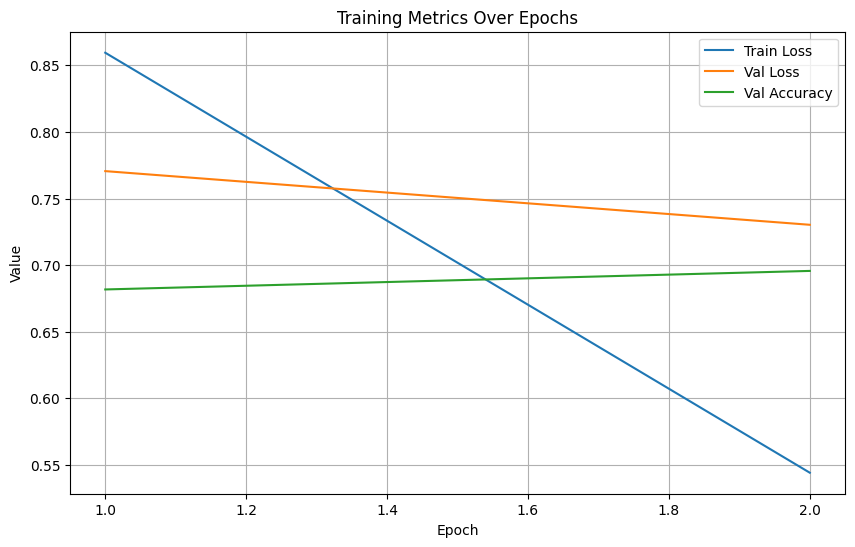

{'train_loss': [0.8594264839849775, 0.544181132600421],
 'val_loss': [0.7705581684907278, 0.7302800350719028],
 'val_accuracy': [0.6817391304347826, 0.6956521739130435]}

In [43]:
# Training Time
# 14:32 00:22
# 14:56 00:24
# 15:48 00:23
# 14:42 00:26
# 33:41 00:58

# 30:34 00:24
# 15:26 00:24
# 15:53 00:25
# 15:32 00:24
# 16:57 00:24
import matplotlib.pyplot as plt

# Plot all metrics in the same graph
plt.figure(figsize=(10, 6))
for key, val in metric_seq.items():
    plt.plot(range(1, len(val) + 1), val, label=key.replace('_', ' ').title())

plt.title('Training Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

metric_seq

In [44]:
# Final Evaluation on Test Set
test_loader = create_data_loader(test, tokenizer, params['batch_size'])
print("\nEvaluating final model on test set...")
test_metrics = evaluate_model(model, test_loader, device)
print(f"Test set metrics: {test_metrics}")


Evaluating final model on test set...


Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 36/36 [01:38<00:00,  2.75s/it]

Test set metrics: {'loss': 0.7401111953788333, 'accuracy': 0.6936466492602262, 'precision': 0.7208506336742385, 'recall': 0.6936466492602262, 'f1': 0.7012997596318774}


In [24]:
# # Set the model to evaluation mode
# model.eval()

# # Example text for prediction
# example_text = "harris leads by 1%"

# # Tokenize the input text
# encoded_input = tokenizer(
#     example_text,
#     return_tensors="pt", # Return PyTorch tensors
#     truncation=True,
#     padding=True
# )
# # Remove token_type_ids if not used
# encoded_input.pop("token_type_ids", None)

# # Perform prediction without gradient computation
# with torch.no_grad():
#     outputs = model(**encoded_input)

# # Get the logits from the model's output
# logits = outputs.logits

# # Get the predicted class (0, 1, or 2)
# predicted_class = torch.argmax(logits, dim=1).item() - 1
# print("Predicted class (-1, 0, 1):", predicted_class)

Predicted class (-1, 0, 1): 1
